In [143]:
from sklearn.datasets import load_iris
import pandas as pd
import math
import numpy as np
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import silhouette_samples, silhouette_score

## Load Dataset

In [144]:
#load iris dataset
data_iris = load_iris()
iris_data, iris_y = load_iris(return_X_y=True)
feature_iris = data_iris['feature_names']

In [145]:
#transform iris into dataframe
iris_X=pd.DataFrame(iris_data)

In [146]:
iris_X.rename(columns = {0:feature_iris[0],1:feature_iris[1],2:feature_iris[2],3:feature_iris[3]}, inplace = True)

## K-Means Algorithm

In [147]:
# return minimum value and maximum value from array
def rangeFeature(data):
    return data.min(),data.max()

In [148]:
# return array that contain all range from every feature
def setRange(data):
    dataMin = []
    dataMax = []
    for index,col in enumerate(data.columns):
        tmpMin,tmpMax=rangeFeature(data[col])
        dataMin.append(tmpMin)
        dataMax.append(tmpMax)
    return dataMin,dataMax

In [149]:
# initialize every centroid based on range every feature
def initCentroid(cluster,dimension,dataMin,dataMax):
    centroid = []
    for i in range(cluster):
        point = []
        for j in range(dimension):
            pos = np.random.uniform(dataMin[j],dataMax[j])
            point.append(pos)
        centroid.append(point)
    return centroid

In [150]:
# calculate distance from 2 point using euclidian distance
def distFromCentroid(point1,point2):
    sumSquare = 0
    dimension = len(point1)
    for i in range(dimension):
        sumSquare += (point1[i]-point2[i])**2
    return sumSquare ** 0.5

In [151]:
# save every distance from every instance
def checkDistCentroid(centroid,data,cluster):
    distAllCentroid = []
    lenData = len(data)
    
    for i in range(cluster):
        distCentroid = []
        for j in range(lenData):
            dist = distFromCentroid(data.loc[j].values,centroid[i])
            distCentroid.append(dist)
        distAllCentroid.append(distCentroid)
    return distAllCentroid

In [152]:
# assign cluster from one instance with closest cluster
def checkCluster(dist,cluster):
    mn = dist[0]
    idx = 0
    for i in range(1,cluster):
        if (mn>dist[i]):
            mn = dist[i]
            idx = i
    return idx

In [153]:
# Save every cluster in all instance to array
def clustering(distance,cluster,lenData):
    clusterNow = []
    for i in range(lenData):
        clusterNow.append(checkCluster(distance[i],cluster))
    return clusterNow

In [154]:
# moving centroid based on average point from new cluster
def moveCentroid(cluster,data):
    lenData = len(data)
    cntCluster = max(cluster) + 1
    centroid = []
    
    for i in range(cntCluster):
        cnt = 0
        point = [0]*len(data.columns)
        # get sum of coordinate one cluster
        for j in range(lenData):
            if (cluster[j]==i):
                cnt+=1
                for k,col in enumerate(data.columns):
                    point[k] += data.loc[j][col]
        # get average of coordinate one cluster
        for j in range(len(data.columns)):
            if (cnt != 0):
                point[j] /= cnt 
        centroid.append(point)
    return centroid

In [155]:
# K-Means Clustering with parameter dataset that used and number of cluster that will formed
# return cluster from dataset
def kmeans(data,cluster):
    dataMin = []
    dataMax = []
    centroid = []
    distance = []
    lenData = len(data)
    clusterNow = []
    prevCluster = []
    
    # set range every columns
    dataMin,dataMax = setRange(data)
    # inisialize centroid
    centroid = initCentroid(cluster,len(data.columns),dataMin,dataMax)
    # check distance from centroid
    distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
    # clustering
    clusterNow = clustering(distance, cluster, lenData)
    
    while(clusterNow != prevCluster):
        prevCluster = clusterNow
        centroid = moveCentroid(clusterNow,data)
        distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
        clusterNow = clustering(distance, cluster, lenData)
    return clusterNow

In [156]:
ans = kmeans(iris_X,3)

## Evaluasi

### Fowlkes_Mallows

In [157]:
fowlkes_mallows_score(ans, iris_y)

0.8112427991975698

### Silhouette Coefficient

In [158]:
silhouette_score(iris_data, ans)

0.5511916046195915

## Visualization K-Means Algorithm
Kami menggambar dalam 2 dimensi untuk setiap pasangan kolom (column1 dan column2) yang mungkin dari dataset yang diberikan. Kemudian hasil clustering direpresentasikan sebagai warna yang berbeda.

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualization_k_means(train_data, number_of_cluster):
    clustering_result = kmeans(train_data, number_of_cluster)
    clustering_res = pd.DataFrame(clustering_result)
    data = pd.concat([iris_X, clustering_res], axis=1)
    data.rename(columns={0:"clustering_result"}, inplace = True)
    column_name = train_data.columns
    column_size = train_data.columns.size
    
    for i in range(column_size):
        for j in range(column_size):
            if(i != j) & (i<j):
                sns.lmplot(column_name[i], column_name[j], data=data, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

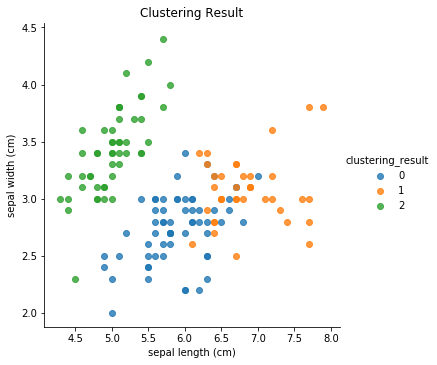

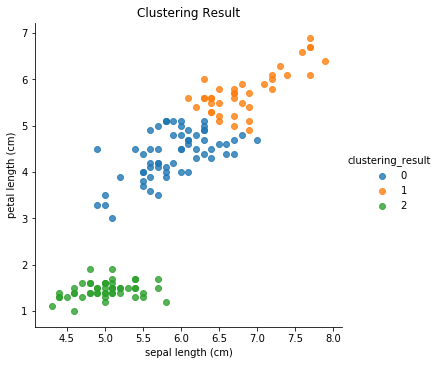

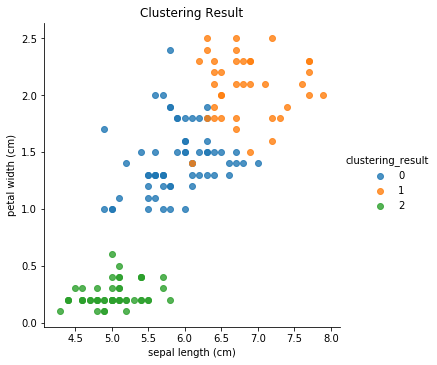

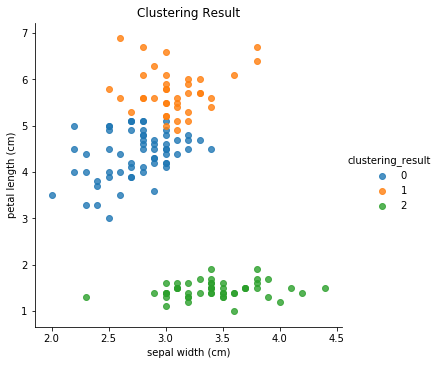

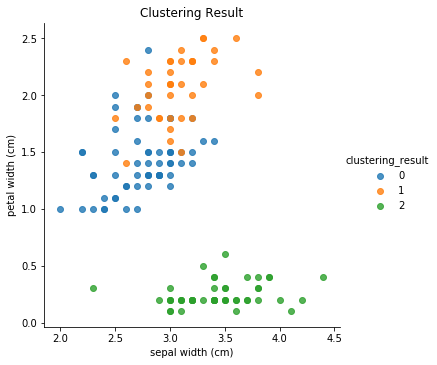

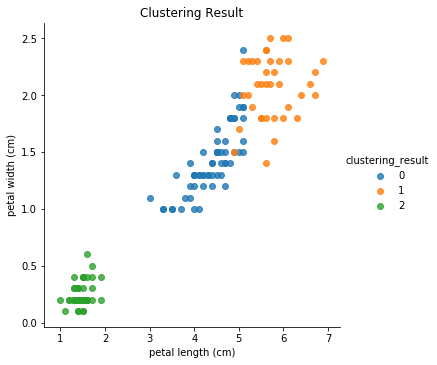

In [160]:
visualization_k_means(iris_X, 3)

## Agglomerative Algorithm

In [161]:
def euclidean_dist(point1, point2):
    distance = 0
    dimension = len(point1)
    
    for i in range(dimension):
        distance += (point1[i]-point2[i])**2
        
    return distance ** 0.5

In [162]:
def init_proximity_matrix(data):
    matrix = [[0 for i in range(len(data))] for j in range(len(data))]
    
    for i in range(len(data)):
        for j in range(i, len(data)):
            if (i != j):
                proximity = euclidean_dist(data.loc[i].values, data.loc[j].values)
                matrix[i][j] = proximity
                matrix[j][i] = proximity
    
    return matrix

In [163]:
def init_cluster(n_cluster):
    clusters = []
    
    for i in range(n_cluster):
        clusters.append(str(i))
        
    return clusters

In [164]:
def find_shortest_dist(proximity_matrix):
    min_distance = float("inf")
    result = [0, 1]
    
    for i in range(len(proximity_matrix)):
        for j in range(i, len(proximity_matrix)):
            if (proximity_matrix[i][j] > 0) and (proximity_matrix[i][j] < min_distance):
                min_distance = proximity_matrix[i][j]
#                 print(min_distance)
                result[0] = i
                result[1] = j
    
    return result

In [165]:
def update_clusters(clusters, cluster1, cluster2):
    updated_clusters = []
    
    for i in range(len(clusters)-1):
        if (i != cluster1):
            if (i >= cluster2):
                updated_clusters.append(clusters[i+1])
            else:
                updated_clusters.append(clusters[i])
        else:
            updated_clusters.append(clusters[cluster1] + "," + clusters[cluster2])
    
    return updated_clusters

In [166]:
def update_proximity_matrix(matrix, cluster1, cluster2, linkage, clusters, data):
    updated_matrix = [[0 for i in range(len(matrix)-1)] for j in range(len(matrix)-1)]

    for i in range(len(updated_matrix)):
        if (i != cluster1):
            idx_i = i
            if (i >= cluster2):
                idx_i += 1

            for j in range(idx_i, len(updated_matrix)):
                if (i != j):
                    if (j != cluster1):
                        if (j >= cluster2):
                            updated_matrix[i][j] = matrix[idx_i][j+1]
                            updated_matrix[j][i] = matrix[idx_i][j+1]
                        else:
                            updated_matrix[i][j] = matrix[idx_i][j]
                            updated_matrix[j][i] = matrix[idx_i][j]
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[idx_i][cluster1] + matrix[idx_i][cluster2])/2
                            updated_matrix[j][i] = (matrix[idx_i][cluster1] + matrix[idx_i][cluster2])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[i], clusters[cluster1], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
        else:
            for j in range(i, len(updated_matrix)):
                if (i != j):
                    if (j >= cluster2):
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[cluster1][j+1] + matrix[cluster2][j+1])/2
                            updated_matrix[j][i] = (matrix[cluster1][j+1] + matrix[cluster2][j+1])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[i], clusters[j], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[cluster1][j] + matrix[cluster2][j])/2
                            updated_matrix[j][i] = (matrix[cluster1][j] + matrix[cluster2][j])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[cluster1], clusters[j], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
                        
    return updated_matrix

In [167]:
def cluster_means_distance(a, b, clusters, data) :
    
    cluster_1 = a.split(',')
    cluster_2 = b.split(',')
    
    means_1 = [0]*len(data.columns)
    for i in range(len(cluster_1)):
        for k,col in enumerate(data.columns):
            means_1[k] += data.loc[i][col]
    
    for i in range(len(data.columns)):
        means_1[i] /= len(cluster_1) 
    
    means_2 = [0]*len(data.columns)
    for i in range(len(cluster_2)):
        for k,col in enumerate(data.columns):
            means_2[k] += data.loc[i][col]
    
    for i in range(len(data.columns)):
        means_2[i] /= len(cluster_2)
    
    distance = 0
    for i in range(len(data.columns)):
        distance += (means_1[i]-means_2[i]) ** 2
        
        
    return (distance) ** 0.5
    

In [168]:
def MakeMatrix(size):
    return [["" for i in range (size)] for j in range(size)]

In [169]:
def agglomerative(data, cluster, linkage):
    n_cluster = len(data)
    proximity_matrix = init_proximity_matrix(data)
    clusters = init_cluster(n_cluster)
    
    if (len(data) > 1):
        idx_row = 0;
        mat_size = len(data)
        mat = MakeMatrix(mat_size)
        for i in range(mat_size):
            mat[idx_row][i] = clusters[i]

        while (n_cluster > cluster):             
            cluster_pair = find_shortest_dist(proximity_matrix)
            
            for i in range(mat_size):
                mat[idx_row+1][i] =  mat[idx_row][i]
            
            pos_1 = -999
            pos_2 = -999
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[0]]):
                    pos_1 = i
                    break
            
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[1]]):
                    pos_2 = i
                    break
            
            
            pos_left = min(pos_1, pos_2)
            pos_right = max(pos_1, pos_2)
            mat[idx_row+1][pos_left] = mat[idx_row+1][pos_left] + "," + mat[idx_row+1][pos_right]
            mat[idx_row+1][pos_right] = ""
            
            clusters = update_clusters(clusters, cluster_pair[0], cluster_pair[1]) 
            
            proximity_matrix = update_proximity_matrix(proximity_matrix, cluster_pair[0], cluster_pair[1], linkage, clusters, data)
            
            n_cluster -= 1
            idx_row +=1
            offset = data
    return clusters, mat, len(data) - cluster

In [170]:
agglo_result_average = agglomerative(iris_X, 3, "average")
print(agglo_result_average[0])

['0,17,40,4,37,7,39,49,27,28,10,48,19,21,46,20,31,36,23,26,43,24,44,5,18,16,32,33,14,15,1,45,12,9,34,25,35,2,3,47,6,11,29,30,8,38,42,13,22,41', '50,52,86,76,77,54,58,65,75,51,56,85,61,71,74,97,63,91,78,73,55,90,66,84,62,68,87,53,89,69,80,81,67,82,92,88,95,96,94,99,59,64,79,57,93,98,60,106,70,127,138,149,101,113,142,121,114,72,83,133,123,126,146,119,134,100,110,147,112,139,141,145,115,136,148,120,143,140,144,124,103,116,137,111,104,128,132,108', '102,125,129,107,130,135,105,122,118,109,117,131']


In [171]:
agglo_result_single = agglomerative(iris_X, 3, "single")
print(agglo_result_single[0])

['0,17,40,4,37,7,39,49,27,28,35,10,48,23,26,43,1,9,34,45,12,29,30,25,2,3,47,8,38,42,11,6,19,21,46,13,24,36,20,31,5,18,16,32,33,44,15,14,22,41', '50,52,86,51,56,54,58,65,75,74,97,77,76,71,53,89,69,80,81,67,82,92,88,94,95,96,99,90,61,55,66,84,63,91,78,73,79,85,59,70,127,138,123,126,146,149,101,113,121,72,83,133,103,116,137,104,128,132,110,147,111,141,145,112,139,120,143,140,144,124,115,136,148,102,125,129,64,100,119,107,130,114,62,68,87,105,122,118,135,134,108,109,57,93,60,98,106,117,131', '142']


In [172]:
agglo_result_complete = agglomerative(iris_X, 3, "complete")
print(agglo_result_complete[0])

['0,17,40,7,39,49,27,28,4,37,35,1,45,12,9,34,25,29,30,2,3,47,42,6,8,38,13,22,41,5,18,10,48,36,20,31,11,24,23,26,43,19,21,46,44,14,15,16,32,33', '50,52,86,77,54,58,76,65,75,51,56,85,63,91,78,73,74,97,68,87,119,70,127,138,149,101,113,142,121,114,72,83,133,123,126,111,146,134,100,136,148,120,143,124,140,144,103,116,137,104,128,132,108,110,147,115,112,139,141,145,102,125,129,107,130,105,122,118,109,135,117,131', '53,89,69,80,81,59,64,79,62,55,90,66,84,61,71,67,82,92,88,95,96,94,99,106,57,93,98,60']


In [173]:
agglo_result_average_group = agglomerative(iris_X, 3, "average-group")
print(agglo_result_average_group[0])

['0,17,5,1,45,2,6,3,47,4,37,7,39,8,38,9,34,11,12,13,14,15,16,18,20,22,24,25,31,32,33,36,40,41,42,43,44,46,55,59,60,61,62,64,67,69,70,71,72,73,76,77,78,10,48,79,19,21,23,26,27,28,29,30,35,49,50,52,51,56,83,85,86,88,90,98,100,102,103,104,106,108,109,111,114,115,117,118,119,121,124,125,129,131,133,134,135,142,146,149,53,89,54,58,57,93,63,91,65,75,66,84,68,87,74,97,80,81,82,92,94,99,95,96,101,113,105,122,107,130,110,147,112,139,116,137,120,143,123,126,127,138,128,132,136,148', '140,144', '141,145']


 ### Convert Result To Array

In [174]:
def get_dict_agglo_cluster_result(agglo_result_string):
    agglo_cluster_result = {}
    i = 1
    for data in agglo_result_string:
        temp = data.split(",")
        for instance in temp:
            agglo_cluster_result[int(instance)] = i
        i = i+1
    return agglo_cluster_result

In [175]:
def convResult(result):
    dict_target = get_dict_agglo_cluster_result(result)
    data = [0]*len(dict_target)
    for key, value in dict_target.items():
        data[key] = value
    return data

In [176]:
arr_agglo_result_average = convResult(agglo_result_average[0])
arr_agglo_result_single = convResult(agglo_result_single[0])
arr_agglo_result_complete = convResult(agglo_result_complete[0])
arr_agglo_result_average_group = convResult(agglo_result_average_group[0])

## Evaluation

### Fowlkes_Mallows

In [177]:
fowlkes_mallows_score(arr_agglo_result_average, iris_y)

0.7421637537684369

In [178]:
fowlkes_mallows_score(arr_agglo_result_single, iris_y)

0.7673442541005148

In [179]:
fowlkes_mallows_score(arr_agglo_result_complete, iris_y)

0.7686371028513819

In [180]:
fowlkes_mallows_score(arr_agglo_result_average_group, iris_y)

0.5590321940207358

### Silhouette Coefficient

In [181]:
silhouette_score(iris_data, arr_agglo_result_average)

0.5340213263943496

In [182]:
silhouette_score(iris_data, arr_agglo_result_single)

0.1327579936611085

In [183]:
silhouette_score(iris_data, arr_agglo_result_complete)

0.5135953221192208

In [184]:
silhouette_score(iris_data, arr_agglo_result_average_group)

-0.12306815802144243

## Visualization Agglomerative Algorithm

## Dendogram
Dendogram tidak ditampilkan karena ukurannya sangat rumit sekali. Bahkan dataset iris yang memiliki 150 instance akan sangat rumit dendogramnya. Oleh karena itu kami menyimpan dendogram dalam file csv

#### Dendogram agglomerative average linkage

In [185]:
# create dendogram and save into file dendogram.csv
agglo_result_average = agglomerative(iris_X, 3, "average")

temp_1 = agglo_result_average[1]
            
headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_1, columns=headers)
df.to_csv("dendogram_agglomerative_average_linkage.csv", sep='\t', encoding='utf-8')

#### Dendogram agglomerative single linkage

In [186]:
# create dendogram and save into file dendogram.csv
agglo_result_single = agglomerative(iris_X, 3, "single")

temp_2 = agglo_result_single[1]
            
headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_2, columns=headers)
df.to_csv("dendogram_agglomerative_complete_linkage.csv", sep='\t', encoding='utf-8')

#### Dendogram agglomerative complete linkage

In [187]:
# create dendogram and save into file dendogram.csv
agglo_result_complete = agglomerative(iris_X, 3, "complete")

temp_3 = agglo_result_single[1]
            
headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_3, columns=headers)
df.to_csv("dendogram_agglomerative_complete_linkage.csv", sep='\t', encoding='utf-8')

#### Dendogram agglomerative average-group linkage

In [188]:
# create dendogram and save into file dendogram.csv
agglo_result_average_group = agglomerative(iris_X, 3, "average-group")

temp_4 = agglo_result_single[1]
            
headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_4, columns=headers)
df.to_csv("dendogram_agglomerative_average-group_linkage.csv", sep='\t', encoding='utf-8')

## Scatter Plot

In [189]:
import copy
def display(train_data, dic_target):
    data_result = copy.deepcopy(train_data)
    column_name = train_data.columns
    column_size = train_data.columns.size
    
    data_result["clustering_result"] = 0
    for key, value in dic_target.items():
        data_result["clustering_result"][key] = value;
    
    for i in range(column_size):
        for j in range(column_size):
            if(i != j) & (i<j):
                sns.lmplot(column_name[i], column_name[j], data=data_result, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()
                

In [190]:
def visualization_agglo_result(train_data, num_cluster, linkage):
    dic_target = get_dict_agglo_cluster_result(agglomerative(iris_X, num_cluster, linkage)[0])
    display(train_data, dic_target)

#### Note : To get desired visualizion aggloromerative result
Please run it in order from line cell that defined function get_dict_agglo_cluster_result(agglo_result_string)

/home/fajar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


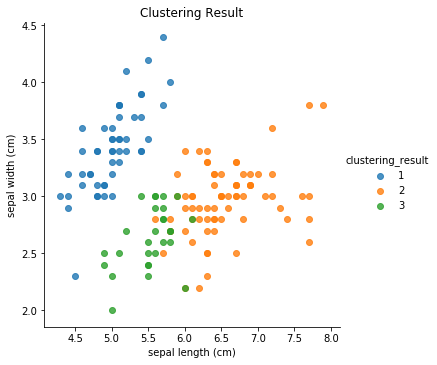

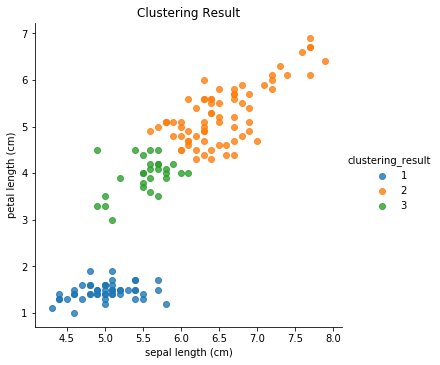

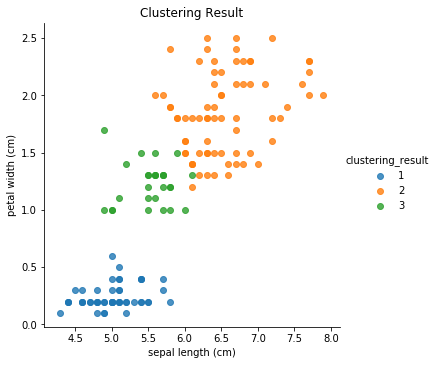

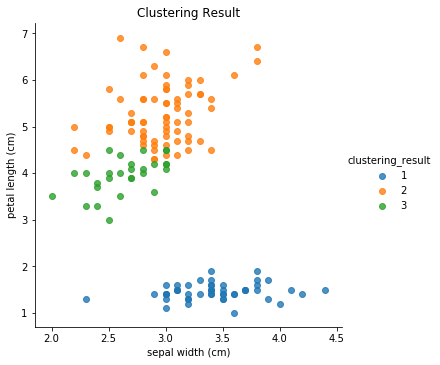

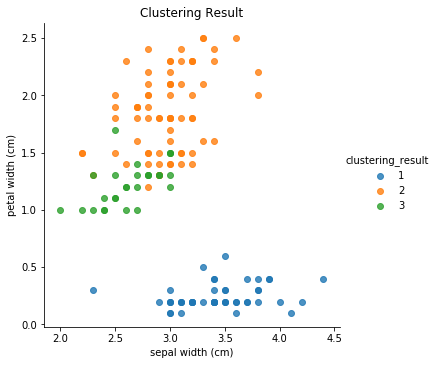

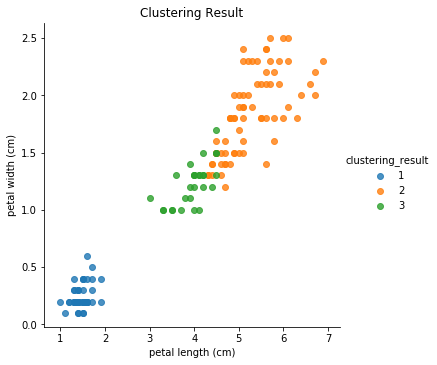

In [191]:
visualization_agglo_result(iris_X, 3, "complete")

## Analisis 
